In [1]:
%load_ext autoreload
%autoreload 2

from __future__ import annotations

# Add parent directory to path.
from pathlib import Path
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/a/64438413
fdir = Path(os.path.abspath('')).resolve() # Directory of current file.
path = fdir/'..'
if path not in sys.path:
    sys.path.append(str(path))

# Complete imports.
import makassar_ml as ml
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import seaborn as sns
sns.set() # Use seaborn themes.

# List all GPUs visible to TensorFlow.
gpus = tf.config.list_physical_devices('GPU')
print(f"Num GPUs Available: {len(gpus)}")
for gpu in gpus:
    print(f"Name: {gpu.name}, Type: {gpu.device_type}")

Num GPUs Available: 1
Name: /physical_device:GPU:0, Type: GPU


In [2]:
keras.backend.clear_session()

In [3]:
# Configure root paths.
config = dict(
    roots=dict(
        hp_tuning_root=Path('~/research/makassar/hp_tuning').expanduser(),
        image_root=Path('~/research/makassar/images').expanduser(),
    ),
)

In [4]:
epochs = 30
batch_size = 128

In [5]:
ds_train, ds_val, ds_test = tfds.load(
    name='plant_village',
    split=['train[0%:70%]', 'train[70%:90%]', 'train[90%:]'],
    shuffle_files=False,
    as_supervised=True,
    with_info=False,
)

def preprocess(images, labels):
    return (
        keras.applications.inception_v3.preprocess_input(tf.cast(images, tf.float32), data_format='channels_last'), 
        labels,
    )

def augment(images, labels):
    aug_images = tf.image.random_flip_left_right(images)
    aug_images = tf.image.random_flip_up_down(aug_images)
    return (aug_images, labels)


ds_train = ds_train.map(preprocess).map(augment)
ds_val = ds_val.map(preprocess).map(augment)
ds_test = ds_test.map(preprocess)

ds_train = ds_train.batch(batch_size)
ds_val = ds_val.batch(batch_size)
ds_test = ds_test.batch(batch_size)

ds_train = ds_train.prefetch(tf.data.AUTOTUNE).cache()
ds_val = ds_val.prefetch(tf.data.AUTOTUNE).cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE).cache()

In [6]:
model = keras.applications.inception_v3.InceptionV3(
    include_top=True,
    weights=None,
    classes=38,
    classifier_activation='softmax',
)

optimizer = keras.optimizers.Adam(learning_rate=1e-3)
metrics = ['accuracy']
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=metrics,
)
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [7]:
model, history, metrics = ml.training.train_evaluate_model(
    model,
    datagen_train=ds_train,
    datagen_val=ds_val,
    datagen_test=ds_test,
    epochs=epochs,
    checkpoint_path=config['roots']['hp_tuning_root']/'inceptionv3'/'inceptionv3.h5',
    history_path=config['roots']['hp_tuning_root']/'inceptionv3'/'inceptionv3_history.csv',
    metrics_path=config['roots']['hp_tuning_root']/'inceptionv3'/'inceptionv3_metrics.json',
)

Epoch 1/30
297/297 [==============================] - 409s 1s/step - loss: 1.6446 - accuracy: 0.5556 - val_loss: 12.1903 - val_accuracy: 0.0695
Epoch 2/30
297/297 [==============================] - 215s 724ms/step - loss: 0.5009 - accuracy: 0.8394 - val_loss: 0.7677 - val_accuracy: 0.7793
Epoch 3/30
297/297 [==============================] - 215s 723ms/step - loss: 0.2547 - accuracy: 0.9169 - val_loss: 0.8986 - val_accuracy: 0.7834
Epoch 4/30
297/297 [==============================] - 214s 722ms/step - loss: 0.1804 - accuracy: 0.9397 - val_loss: 0.3703 - val_accuracy: 0.8868
Epoch 5/30
297/297 [==============================] - 214s 722ms/step - loss: 0.1427 - accuracy: 0.9518 - val_loss: 0.3619 - val_accuracy: 0.8923
Epoch 6/30
297/297 [==============================] - 214s 722ms/step - loss: 0.0988 - accuracy: 0.9678 - val_loss: 0.5320 - val_accuracy: 0.8696
Epoch 7/30
297/297 [==============================] - 214s 722ms/step - loss: 0.0940 - accuracy: 0.9692 - val_loss: 0.9113 - v

In [9]:
model.save(config['roots']['hp_tuning_root']/'inceptionv3'/'inceptionv3.h5')

/home/acd1797/research/makassar/images/inceptionv3.png


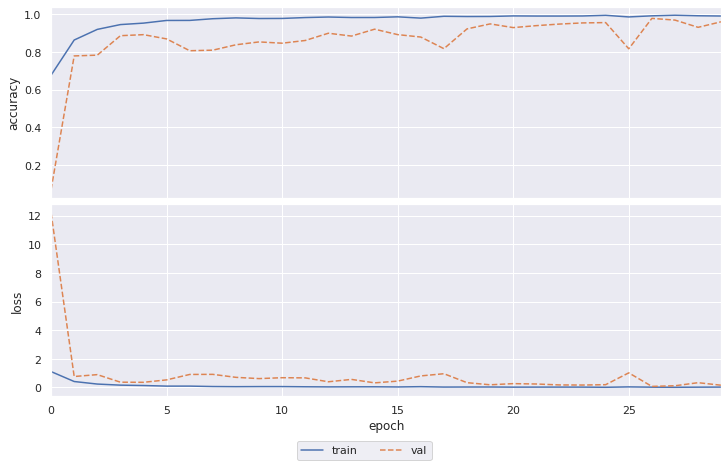

In [8]:
# Plot train/val performance for best model.
allmetrics = ['loss', 'accuracy']
fig, ax = plt.subplots(nrows=len(allmetrics), ncols=1, figsize=(10,len(allmetrics)*3), sharex=True, constrained_layout=True)
for j, key in enumerate(sorted(allmetrics)):
    ax[j].plot(history[key], label=f'train', linestyle='-')
    ax[j].plot(history[f"val_{key}"], label=f'val', linestyle='--')
    ax[j].set_xlim(0, len(history[key])-1)
    if j == len(allmetrics)-1:
        ax[j].set_xlabel('epoch')
    ax[j].set_ylabel(key)
    # ax[j].legend(loc='upper left')

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5,0.0))
path = Path(config['roots']['image_root'])/f"inceptionv3.png"
fig.savefig(path, bbox_inches='tight')
print(path)